ニューラルネットワークシミュレーション
----

tutorial.c をjuliaに置き換えてみる．

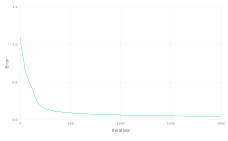

In [223]:
function calc_output(wih, who, in_p)
    p = in_p'
    o_h = tanh(wih * vcat(p, 1.0))
    o_o = tanh(who * vcat(o_h, 1.0))
end

function test_network(wih, who, in_p, tg_p)
    sum_sq_err = 0.0
    for i = 1:size(in_p, 1)
        o = calc_output(wih, who, in_p[i, :])
        #println(o - tg_p[i,:])
#        println("o:", size(o), " ", o, "tg", size(tg_p[i, :]), " ", tg_p[i, :])
        sum_sq_err += sum((o - tg_p[i, :]').^2)
    end
    sum_sq_err / size(in_p, 1)
end

function train_network(wih, who, in_p, tg_p, eta0)
    for p = 1:size(in_p, 1)
        #forward propagation
        apat = in_p[p, :]'
        net_h = wih * vcat(apat, 1.0)
        o_h = tanh(net_h)
        net_o = who * vcat(o_h, 1.0)
        o_o = tanh(net_o)
        
        #calc_delta
        del_o = (tg_p[p, :]' - o_o) .* (1.0 - o_o.^2)
        d = who' * del_o
        del_h = d[1:end-1] .* (1.0 - o_h.^2)
        
        #adjust weight
        d_wih = eta0 * del_h * vcat(apat, 1.0)'
        d_who = eta0 * del_o * vcat(o_h, 1.0)'
        wih = wih + d_wih
        who = who + d_who
#        println(eta0)
#        println(wih)
    end
    return (wih, who)
end

using Gadfly

inp = 3
hid = 2
out = 1

max_iter = 2000
min_error = 0.001

iwr = 1.0
eta = 0.05
rnd_seed = 1    # not in used

ex_file = "parity.in"
tg_file = "parity.tg"
wt_file = "parity.wt"
rms_file = "parity.rms"

iter = 0
eta = 0.1

Wih = (rand(hid, inp + 1) - 0.5) * iwr * 2.0
Who = (rand(out, hid + 1) - 0.5) * iwr * 2.0

input_p = open(readdlm, ex_file, "r")
target_p = open(readdlm, tg_file, "r")
#target_p = hcat(target_p, -target_p)

ave_rms = 999.0
test_network(Wih, Who, input_p, target_p)
err = []
while (ave_rms > min_error) & (iter < max_iter)
    ave_rms = sqrt(test_network(Wih, Who, input_p, target_p))
    push!(err, ave_rms)
    Wih, Who = train_network(Wih, Who, input_p, target_p, eta)
#    println("iter:", iter, " err:", ave_rms)

    iter += 1
end

set_default_plot_size(9inch, 9inch / golden);
plot(y = err, Geom.line,
Guide.xlabel("Iterations"), Guide.ylabel("Error"))